Following is a simple HPC cloud simulation. This simulation models:
- A set of HPC nodes (e.g., CPU clusters)
- Jobs arriving with varying computational requirements (measured in FLOPS or execution time)
- A central scheduler that allocates jobs to available nodes
- Job queueing and execution tracking

In [1]:
import simpy
import random

# Simulation configuration
NUM_NODES = 4                 # Number of HPC nodes
SIM_TIME = 100                # Total simulation time
JOB_INTERVAL = 5              # Mean time between job arrivals
MIN_EXEC_TIME = 5             # Minimum job duration
MAX_EXEC_TIME = 15            # Maximum job duration

class HPCNode:
    def __init__(self, env, node_id):
        self.env = env
        self.node_id = node_id
        self.resource = simpy.Resource(env, capacity=1)  # One job at a time

class HPCJob:
    def __init__(self, job_id, exec_time):
        self.job_id = job_id
        self.exec_time = exec_time

def job_generator(env, nodes):
    job_id = 0
    while True:
        exec_time = random.randint(MIN_EXEC_TIME, MAX_EXEC_TIME)
        job = HPCJob(job_id, exec_time)
        env.process(schedule_job(env, job, nodes))
        yield env.timeout(random.expovariate(1.0 / JOB_INTERVAL))
        job_id += 1

def schedule_job(env, job, nodes):
    # Simple scheduler: find the first available node
    for node in nodes:
        if node.resource.count < node.resource.capacity:
            with node.resource.request() as req:
                yield req
                print(f"Time {env.now:.1f}: Job {job.job_id} starts on Node {node.node_id} (duration {job.exec_time})")
                yield env.timeout(job.exec_time)
                print(f"Time {env.now:.1f}: Job {job.job_id} finishes on Node {node.node_id}")
                return

    # If all nodes are busy, wait for the first one to be available (FIFO)
    chosen_node = random.choice(nodes)  # Can replace with smarter scheduling
    with chosen_node.resource.request() as req:
        yield req
        print(f"Time {env.now:.1f}: Job {job.job_id} waits and starts on Node {chosen_node.node_id} (duration {job.exec_time})")
        yield env.timeout(job.exec_time)
        print(f"Time {env.now:.1f}: Job {job.job_id} finishes on Node {chosen_node.node_id}")

# Initialize simulation
env = simpy.Environment()
nodes = [HPCNode(env, i) for i in range(NUM_NODES)]

env.process(job_generator(env, nodes))
env.run(until=SIM_TIME)

Time 0.0: Job 0 starts on Node 0 (duration 15)
Time 5.9: Job 1 starts on Node 1 (duration 15)
Time 7.3: Job 2 starts on Node 2 (duration 6)
Time 13.3: Job 2 finishes on Node 2
Time 15.0: Job 0 finishes on Node 0
Time 20.9: Job 1 finishes on Node 1
Time 32.0: Job 3 starts on Node 0 (duration 13)
Time 33.2: Job 4 starts on Node 1 (duration 8)
Time 36.6: Job 5 starts on Node 2 (duration 8)
Time 38.3: Job 6 starts on Node 3 (duration 6)
Time 41.2: Job 4 finishes on Node 1
Time 43.9: Job 8 starts on Node 1 (duration 11)
Time 44.3: Job 6 finishes on Node 3
Time 44.6: Job 5 finishes on Node 2
Time 44.6: Job 7 waits and starts on Node 2 (duration 9)
Time 45.0: Job 3 finishes on Node 0
Time 48.5: Job 9 starts on Node 0 (duration 7)
Time 52.8: Job 10 starts on Node 3 (duration 9)
Time 53.6: Job 7 finishes on Node 2
Time 53.6: Job 11 starts on Node 2 (duration 10)
Time 54.9: Job 8 finishes on Node 1
Time 55.5: Job 9 finishes on Node 0
Time 57.4: Job 12 starts on Node 0 (duration 10)
Time 58.8: Jo

#### Introducing multi-job handling per node constrained by resource limits like CPU units or memory bandwidth is essential for modeling realistic HPC systems.

The model contains each node with a total CPU capacity (e.g., 100 CPU units), and each job will require a certain number of CPU units to run. The node can accept multiple jobs as long as the total CPU usage does not exceed its limit.

TO DO: I might need to go back to QCloudSim codes to conduct internal audit to make sure the scheduling is correct. Following codes can be used as references.  

In [13]:
import simpy
import random

# Configurations
NUM_NODES = 3
SIM_TIME = 100
JOB_INTERVAL = 5
MIN_EXEC_TIME = 5
MAX_EXEC_TIME = 15
MAX_CPU_CAPACITY = 20  # Total CPU units per node
MIN_JOB_CPU = 10        # Job requires between 10 and 40 CPU units
MAX_JOB_CPU = 20

class HPCNode:
    def __init__(self, env, node_id):
        self.env = env
        self.node_id = node_id
        self.cpu = simpy.Container(env, capacity=MAX_CPU_CAPACITY, init=MAX_CPU_CAPACITY)

class HPCJob:
    def __init__(self, job_id, exec_time, cpu_required):
        self.job_id = job_id
        self.exec_time = exec_time
        self.cpu_required = cpu_required

def job_generator(env, nodes):
    job_id = 0
    while True:
        exec_time = random.randint(MIN_EXEC_TIME, MAX_EXEC_TIME)
        cpu_required = random.randint(MIN_JOB_CPU, MAX_JOB_CPU)
        job = HPCJob(job_id, exec_time, cpu_required)
        env.process(schedule_job(env, job, nodes))
        yield env.timeout(random.expovariate(1 / JOB_INTERVAL))
        job_id += 1

def schedule_job(env, job, nodes):
    # Find a node with enough available CPU
    for node in nodes:
        if node.cpu.level >= job.cpu_required:
            yield node.cpu.get(job.cpu_required)
            print(f"Time {env.now:.1f}: Job {job.job_id} starts on Node {node.node_id} (CPU {job.cpu_required}, duration {job.exec_time})")
            yield env.timeout(job.exec_time)
            node.cpu.put(job.cpu_required)
            print(f"Time {env.now:.1f}: Job {job.job_id} finishes on Node {node.node_id}")
            return

    # If no node has enough free CPU now, wait on a randomly chosen node
    chosen_node = random.choice(nodes)
    yield chosen_node.cpu.get(job.cpu_required)
    print(f"Time {env.now:.1f}: Job {job.job_id} waits and starts on Node {chosen_node.node_id} (CPU {job.cpu_required}, duration {job.exec_time})")
    yield env.timeout(job.exec_time)
    chosen_node.cpu.put(job.cpu_required)
    print(f"Time {env.now:.1f}: Job {job.job_id} finishes on Node {chosen_node.node_id}")

# Initialize environment and nodes
env = simpy.Environment()
nodes = [HPCNode(env, i) for i in range(NUM_NODES)]

# Start the job generator
env.process(job_generator(env, nodes))
env.run(until=SIM_TIME)

Time 0.0: Job 0 starts on Node 0 (CPU 15, duration 13)
Time 7.4: Job 1 starts on Node 1 (CPU 13, duration 15)
Time 8.2: Job 2 starts on Node 2 (CPU 18, duration 6)
Time 13.0: Job 0 finishes on Node 0
Time 13.0: Job 3 waits and starts on Node 0 (CPU 17, duration 11)
Time 14.2: Job 2 finishes on Node 2
Time 16.9: Job 4 starts on Node 2 (CPU 17, duration 15)
Time 22.4: Job 1 finishes on Node 1
Time 22.4: Job 7 starts on Node 1 (CPU 13, duration 13)
Time 24.0: Job 3 finishes on Node 0
Time 24.0: Job 5 waits and starts on Node 0 (CPU 20, duration 15)
Time 31.9: Job 4 finishes on Node 2
Time 31.9: Job 6 waits and starts on Node 2 (CPU 19, duration 15)
Time 35.4: Job 7 finishes on Node 1
Time 35.4: Job 10 waits and starts on Node 1 (CPU 18, duration 6)
Time 39.0: Job 5 finishes on Node 0
Time 39.0: Job 9 waits and starts on Node 0 (CPU 20, duration 11)
Time 41.4: Job 10 finishes on Node 1
Time 41.4: Job 13 waits and starts on Node 1 (CPU 11, duration 9)
Time 46.9: Job 6 finishes on Node 2
Tim

📉 Current Limitations

While it provides a realistic base, the current model is simple and general-purpose. It doesn’t yet include:
- Job queuing / backoff policies (e.g., FIFO, SJF)
- Memory, disk, or network I/O constraints
- Job deadlines or priorities
- Cost/energy accounting
- Cluster-level coordination (e.g., SLURM-like behavior)
- Job types (e.g., MPI or multi-node jobs)


🧭 What’s Next?

Possibilities are:
- ⚡ Simulate power usage or cooling cost based on CPU load.
- 💰 Add pricing models or billing for users.


We also have to consider that this simulation will eventually merge into QCloudSim


Following functionality are added. 

job_queue:
-	Implemented as a deque to store jobs in arrival order. 
    
scheduler:
-	Continuously checks the queue. 
-	Picks the first job (FIFO). 
-	Waits if no node has enough CPU. 

Separation of Concerns:
-	Job generation, scheduling, and execution are now distinct processes, making it easier to add other policies later.

In [14]:
import simpy
import random
from collections import deque

# ---- Simulation Configuration ----
NUM_NODES = 3
SIM_TIME = 100
JOB_INTERVAL = 5
MIN_EXEC_TIME = 5
MAX_EXEC_TIME = 15
MAX_CPU_CAPACITY = 100
MIN_JOB_CPU = 10
MAX_JOB_CPU = 40

# ---- Node Definition ----
class HPCNode:
    def __init__(self, env, node_id):
        self.env = env
        self.node_id = node_id
        self.cpu = simpy.Container(env, capacity=MAX_CPU_CAPACITY, init=MAX_CPU_CAPACITY)

# ---- Job Definition ----
class HPCJob:
    def __init__(self, job_id, exec_time, cpu_required, arrival_time):
        self.job_id = job_id
        self.exec_time = exec_time
        self.cpu_required = cpu_required
        self.arrival_time = arrival_time

# ---- Job Generator ----
def job_generator(env, job_queue):
    job_id = 0
    while True:
        exec_time = random.randint(MIN_EXEC_TIME, MAX_EXEC_TIME)
        cpu_required = random.randint(MIN_JOB_CPU, MAX_JOB_CPU)
        job = HPCJob(job_id, exec_time, cpu_required, env.now)
        job_queue.append(job)
        print(f"Time {env.now:.1f}: Job {job.job_id} arrives (CPU {job.cpu_required}, duration {job.exec_time})")
        yield env.timeout(random.expovariate(1.0 / JOB_INTERVAL))
        job_id += 1

# ---- Scheduler ----
def scheduler(env, job_queue, nodes):
    while True:
        if job_queue:
            job = job_queue[0]  # Peek at first job (FIFO)

            # Try to find a node with enough CPU
            node = next((n for n in nodes if n.cpu.level >= job.cpu_required), None)

            if node:  # If found, dispatch job
                job_queue.popleft()
                env.process(run_job(env, job, node))
            else:
                # No node available now; check again later
                yield env.timeout(1)
                continue

        yield env.timeout(0.5)  # Avoid busy-waiting

# ---- Job Execution ----
def run_job(env, job, node):
    # Reserve CPU
    yield node.cpu.get(job.cpu_required)
    print(f"Time {env.now:.1f}: Job {job.job_id} starts on Node {node.node_id} (CPU {job.cpu_required})")

    # Simulate execution
    yield env.timeout(job.exec_time)

    # Release CPU
    yield node.cpu.put(job.cpu_required)
    print(f"Time {env.now:.1f}: Job {job.job_id} finishes on Node {node.node_id}")

# ---- Simulation Setup ----
env = simpy.Environment()
nodes = [HPCNode(env, i) for i in range(NUM_NODES)]
job_queue = deque()

env.process(job_generator(env, job_queue))
env.process(scheduler(env, job_queue, nodes))

env.run(until=SIM_TIME)

Time 0.0: Job 0 arrives (CPU 23, duration 8)
Time 0.0: Job 0 starts on Node 0 (CPU 23)
Time 3.9: Job 1 arrives (CPU 33, duration 10)
Time 4.0: Job 1 starts on Node 0 (CPU 33)
Time 8.0: Job 0 finishes on Node 0
Time 9.4: Job 2 arrives (CPU 15, duration 5)
Time 9.4: Job 3 arrives (CPU 16, duration 15)
Time 9.5: Job 2 starts on Node 0 (CPU 15)
Time 10.0: Job 3 starts on Node 0 (CPU 16)
Time 11.6: Job 4 arrives (CPU 28, duration 12)
Time 12.0: Job 4 starts on Node 0 (CPU 28)
Time 14.0: Job 1 finishes on Node 0
Time 14.5: Job 2 finishes on Node 0
Time 22.1: Job 5 arrives (CPU 28, duration 11)
Time 22.5: Job 5 starts on Node 0 (CPU 28)
Time 24.0: Job 4 finishes on Node 0
Time 25.0: Job 3 finishes on Node 0
Time 33.5: Job 5 finishes on Node 0
Time 36.4: Job 6 arrives (CPU 15, duration 14)
Time 36.5: Job 6 starts on Node 0 (CPU 15)
Time 48.0: Job 7 arrives (CPU 33, duration 13)
Time 48.5: Job 7 starts on Node 0 (CPU 33)
Time 50.5: Job 6 finishes on Node 0
Time 50.8: Job 8 arrives (CPU 29, dura

In [19]:
import simpy
import random
from collections import deque
import matplotlib.pyplot as plt

# ---- Simulation Configuration ----
NUM_NODES = 3
SIM_TIME = 100
JOB_INTERVAL = 5

MAX_CPU_CAPACITY = 100
MAX_MEM_CAPACITY = 256  # in GB

MIN_EXEC_TIME = 5
MAX_EXEC_TIME = 15

MIN_JOB_CPU = 10
MAX_JOB_CPU = 40

MIN_JOB_MEM = 20
MAX_JOB_MEM = 100

# ---- Global Metrics ----
job_records = {}

# ---- HPC Node ----
class HPCNode:
    def __init__(self, env, node_id):
        self.env = env
        self.node_id = node_id
        self.cpu = simpy.Container(env, capacity=MAX_CPU_CAPACITY, init=MAX_CPU_CAPACITY)
        self.mem = simpy.Container(env, capacity=MAX_MEM_CAPACITY, init=MAX_MEM_CAPACITY)

# ---- HPC Job ----
class HPCJob:
    def __init__(self, job_id, exec_time, cpu_required, mem_required, arrival_time):
        self.job_id = job_id
        self.exec_time = exec_time
        self.cpu_required = cpu_required
        self.mem_required = mem_required
        self.arrival_time = arrival_time

# ---- Job Generator ----
def job_generator(env, job_queue):
    job_id = 0
    while True:
        exec_time = random.randint(MIN_EXEC_TIME, MAX_EXEC_TIME)
        cpu_required = random.randint(MIN_JOB_CPU, MAX_JOB_CPU)
        mem_required = random.randint(MIN_JOB_MEM, MAX_JOB_MEM)

        job = HPCJob(job_id, exec_time, cpu_required, mem_required, env.now)
        job_queue.append(job)

        job_records[job_id] = {
            'arrival_time': env.now,
            'exec_time': exec_time,
            'cpu_required': cpu_required,
            'mem_required': mem_required,
            'start_time': None,
            'end_time': None,
            'node_id': None,
        }

        print(f"Time {env.now:.1f}: Job {job_id} arrives (CPU {cpu_required}, MEM {mem_required}, duration {exec_time})")
        yield env.timeout(random.expovariate(1.0 / JOB_INTERVAL))
        job_id += 1

# ---- Scheduler ----
def scheduler(env, job_queue, nodes):
    while True:
        if job_queue:
            job = job_queue[0]  # FIFO
            node = next(
                (n for n in nodes if n.cpu.level >= job.cpu_required and n.mem.level >= job.mem_required),
                None
            )

            if node:
                job_queue.popleft()
                env.process(run_job(env, job, node))
            else:
                yield env.timeout(1)
                continue

        yield env.timeout(0.5)

# ---- Job Runner ----
def run_job(env, job, node):
    yield node.cpu.get(job.cpu_required)
    yield node.mem.get(job.mem_required)

    start_time = env.now
    job_records[job.job_id]['start_time'] = start_time
    job_records[job.job_id]['node_id'] = node.node_id

    print(f"Time {start_time:.1f}: Job {job.job_id} starts on Node {node.node_id} (CPU {job.cpu_required}, MEM {job.mem_required})")
    yield env.timeout(job.exec_time)

    end_time = env.now
    job_records[job.job_id]['end_time'] = end_time

    yield node.cpu.put(job.cpu_required)
    yield node.mem.put(job.mem_required)

    print(f"Time {end_time:.1f}: Job {job.job_id} finishes on Node {node.node_id}")

# ---- Final Metrics ----
def print_metrics():
    print("\n--- Simulation Metrics Summary ---")
    total_jobs = 0
    total_waiting = 0
    total_turnaround = 0

    for job_id, record in job_records.items():
        start = record['start_time']
        end = record['end_time']
        arrival = record['arrival_time']

        if start is None or end is None or arrival is None:
            print(f"Job {job_id}: Not completed (Start: {start}, End: {end})")
            continue

        wait_time = start - arrival
        turnaround = end - arrival
        total_waiting += wait_time
        total_turnaround += turnaround
        total_jobs += 1

        print(f"Job {job_id}: Wait = {wait_time:.1f}, Turnaround = {turnaround:.1f}, Node = {record['node_id']}")

    if total_jobs == 0:
        print("No completed jobs.")
        return

    avg_waiting = total_waiting / total_jobs
    avg_turnaround = total_turnaround / total_jobs

    print(f"\nCompleted Jobs: {total_jobs}")
    print(f"Average Waiting Time: {avg_waiting:.2f}")
    print(f"Average Turnaround Time: {avg_turnaround:.2f}")
    print(f"Simulation Duration: {SIM_TIME}")

def utilization_monitor(env, nodes, interval=1.0):
    while True:
        for node in nodes:
            used_cpu = MAX_CPU_CAPACITY - node.cpu.level
            used_mem = MAX_MEM_CAPACITY - node.mem.level
            cpu_utilization[node.node_id].append((env.now, used_cpu))
            mem_utilization[node.node_id].append((env.now, used_mem))
        yield env.timeout(interval)
        
def plot_utilization():
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True)

    # CPU Utilization
    for node_id, samples in cpu_utilization.items():
        times, usages = zip(*samples)
        axs[0].plot(times, usages, label=f'Node {node_id}')
    axs[0].set_ylabel('CPU Used')
    axs[0].set_title('CPU Utilization Over Time')
    axs[0].legend()
    axs[0].grid(True)

    # Memory Utilization
    for node_id, samples in mem_utilization.items():
        times, usages = zip(*samples)
        axs[1].plot(times, usages, label=f'Node {node_id}')
    axs[1].set_ylabel('Memory Used (GB)')
    axs[1].set_xlabel('Time')
    axs[1].set_title('Memory Utilization Over Time')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()
    
# ---- SimPy Environment ----
env = simpy.Environment()
nodes = [HPCNode(env, i) for i in range(NUM_NODES)]
cpu_utilization = {node.node_id: [] for node in nodes}
mem_utilization = {node.node_id: [] for node in nodes}
job_queue = deque()

env.process(job_generator(env, job_queue))
env.process(scheduler(env, job_queue, nodes))
env.process(utilization_monitor(env, nodes))
env.run(until=SIM_TIME)

print_metrics()

Time 0.0: Job 0 arrives (CPU 20, MEM 83, duration 13)
Time 0.0: Job 0 starts on Node 0 (CPU 20, MEM 83)
Time 4.0: Job 1 arrives (CPU 24, MEM 28, duration 8)
Time 4.0: Job 1 starts on Node 0 (CPU 24, MEM 28)
Time 8.5: Job 2 arrives (CPU 23, MEM 78, duration 9)
Time 8.5: Job 2 starts on Node 0 (CPU 23, MEM 78)
Time 12.0: Job 1 finishes on Node 0
Time 12.4: Job 3 arrives (CPU 33, MEM 30, duration 13)
Time 12.5: Job 3 starts on Node 0 (CPU 33, MEM 30)
Time 13.0: Job 0 finishes on Node 0
Time 16.2: Job 4 arrives (CPU 10, MEM 49, duration 6)
Time 16.5: Job 4 starts on Node 0 (CPU 10, MEM 49)
Time 17.5: Job 2 finishes on Node 0
Time 22.5: Job 4 finishes on Node 0
Time 24.7: Job 5 arrives (CPU 34, MEM 81, duration 7)
Time 25.0: Job 5 starts on Node 0 (CPU 34, MEM 81)
Time 25.5: Job 3 finishes on Node 0
Time 26.7: Job 6 arrives (CPU 22, MEM 32, duration 11)
Time 26.7: Job 7 arrives (CPU 31, MEM 71, duration 15)
Time 27.0: Job 6 starts on Node 0 (CPU 22, MEM 32)
Time 27.5: Job 7 starts on Node 0

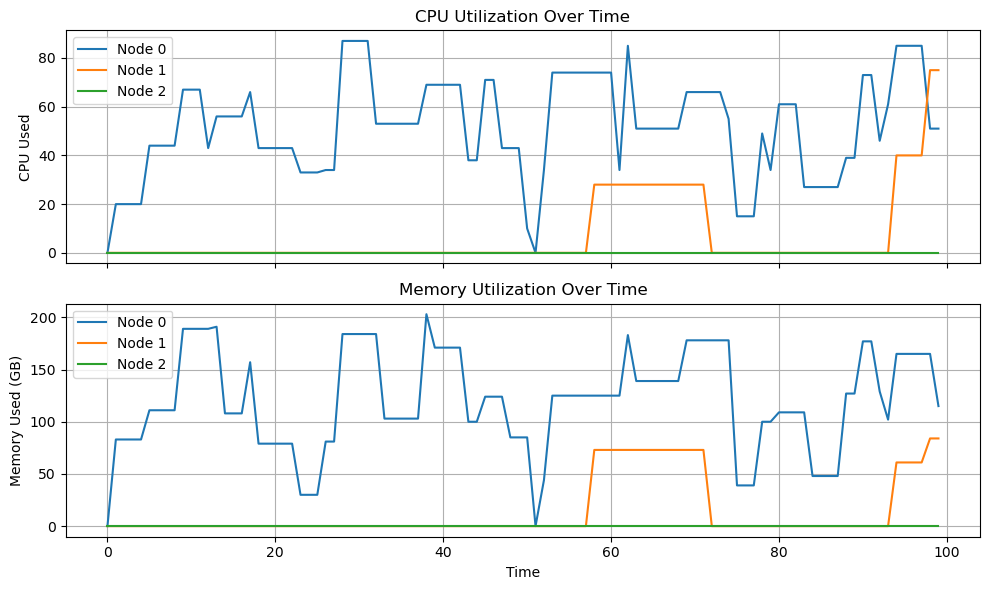

In [20]:
plot_utilization()